In [1]:
import numpy as np
import cv2 as cv 
import matplotlib.pyplot as plt 

%matplotlib inline

# configura ticks para nao aparecerem
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['axes.grid'] = False


## Input Images

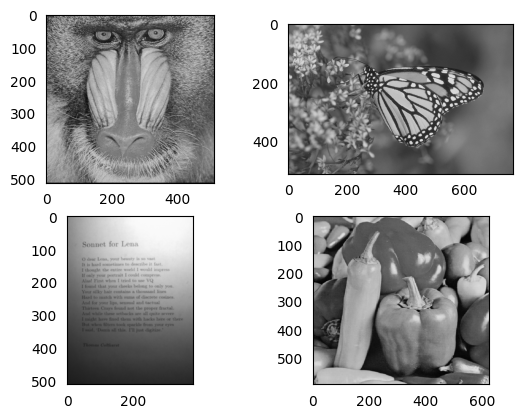

(628, 556)


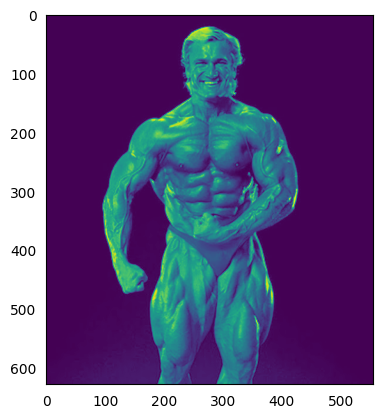

In [2]:
baboon = cv.imread('baboon.pgm')
cidade = cv.imread('monarch.pgm')
sea = cv.imread('sonnet.pgm')
peppers = cv.imread('peppers.pgm')
tom_platz = cv.imread('tom_platz.jpeg', cv.IMREAD_GRAYSCALE)#[:,:,::-1]

images = [baboon, cidade, sea, peppers]

fig, ax = plt.subplots(2,2)
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(images[i*2 + j])
plt.show()
plt.imshow(tom_platz)
print(tom_platz.shape)

### Classe suporte para testar as funções em batches


In [3]:
def show_dict(d):
    total = np.sum(list(d.values()))
    brancos = (d.get(0, 0)/total) 
    pretos = 1 - brancos
    print(f'Pontos pretos {brancos * 100 :.2f}%\nPontos brancos {pretos * 100:.2f}%')

class Autoplotter:

    def __init__(self, func, og_img, parameters):

        assert len(parameters) % 2 == 0

        self.n_rows = len(parameters) // 2 
        self.n_colums = len(parameters) // self.n_rows

        if self.n_rows > self.n_colums:
            self.n_colums = len(parameters) // 2 
            self.n_rows = len(parameters) // self.n_rows

        self.img = og_img
        self.func = func
        self.parameters = parameters
        self.save_name = func.__name__

    def generate_plots(self, labels, title, sz=(8,8), top_size=1, adjust = None):
        #TODO : ADD name to save files and folder
        imgs = [self.func(self.img, *(p)) for p in self.parameters]
        fig, axs = plt.subplots(self.n_rows, self.n_colums, figsize=sz)
        fig.suptitle(title)
        # fig.tight_layout()
        fig.subplots_adjust(top=top_size)

        if adjust != None:
            plt.subplots_adjust(hspace=adjust)

        for i in range(self.n_rows):
            for j in range(self.n_colums):
                axs[i, j].imshow(imgs[i*self.n_colums + j])
                axs[i, j].set_title(labels[i*self.n_colums + j])
                # axs[i, j].axison = False
                unique, counts = np.unique(imgs[i*self.n_colums + j], return_counts= True)

                print(f'Imagem: {i},{j}')
                show_dict(dict(zip(unique, counts)))
                # print(dict(zip(unique, counts)))

        fig1, axs1 = plt.subplots(self.n_rows, self.n_colums, figsize= (sz[0] - 1, sz[1] - 1))
        fig1.suptitle(title + " histogram")

        for i in range(self.n_rows):
            for j in range(self.n_colums):
                axs1[i, j].hist(imgs[i*self.n_colums + j].ravel(), 256, [0, 256])
                axs1[i, j].set_title(labels[i*self.n_colums + j])


        fig1.tight_layout()
        try: 
            fig.savefig(f"./processed_imgs/{self.save_name}.png")
            fig1.savefig(f"./processed_imgs/{self.save_name}_histogram.png")

        except FileNotFoundError:
            pass

#### Métodos de limiarização


Método Global

Imagem: 0,0
Pontos pretos 3.74%
Pontos brancos 96.26%
Imagem: 0,1
Pontos pretos 24.83%
Pontos brancos 75.17%
Imagem: 1,0
Pontos pretos 42.92%
Pontos brancos 57.08%
Imagem: 1,1
Pontos pretos 83.78%
Pontos brancos 16.22%


FileNotFoundError: [Errno 2] No such file or directory: './processed_imgs/thresholding_global.png'

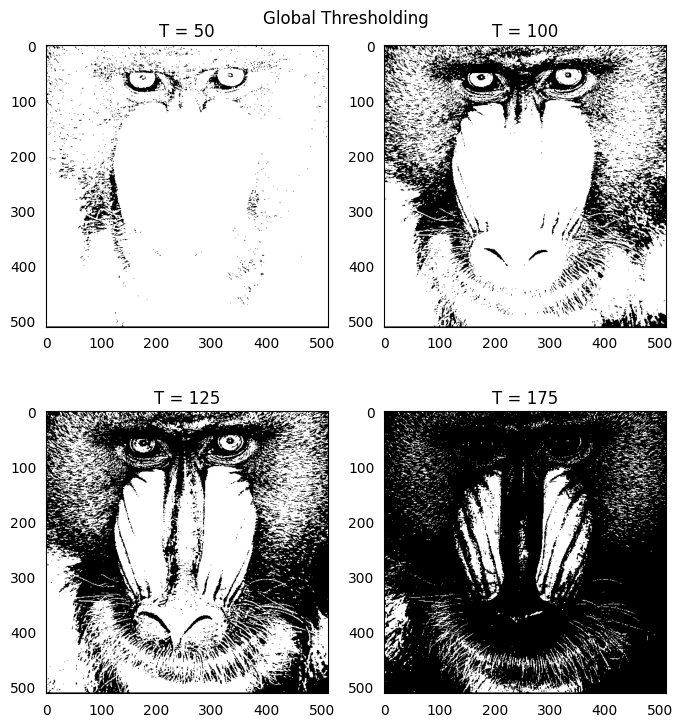

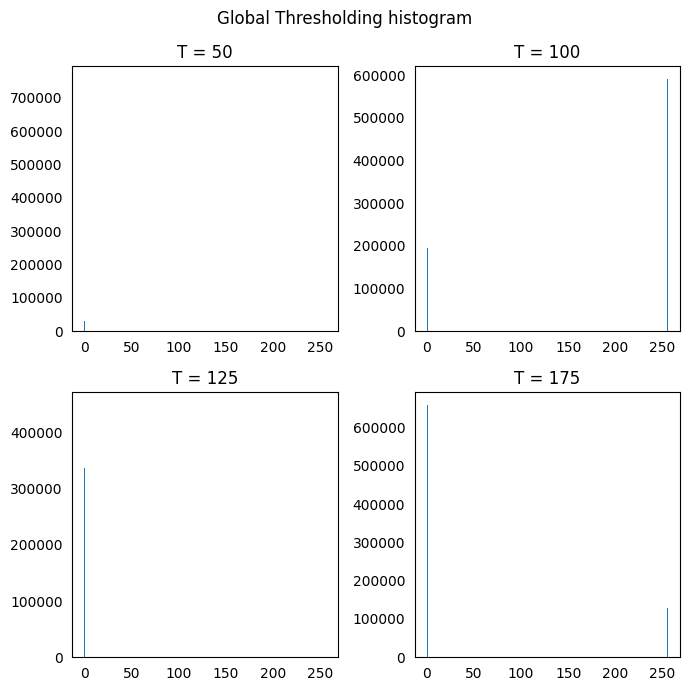

In [4]:
def thresholding_global(img, T=50):
    res = np.zeros_like(img)
    res[img >= T] = 255
    return res

def foo(img, k):
    return img

test_q1_parameters = [[50], [100], [125], [175]]
test_q1_label = ["T = " + str(*(t)) for t in test_q1_parameters]

auto_q1 = Autoplotter(thresholding_global, baboon, test_q1_parameters)

auto_q1.generate_plots(test_q1_label, "Global Thresholding", top_size=.95)

Método de Otsu

Pontos brancos 62.66%
Pontos pretos 37.34%


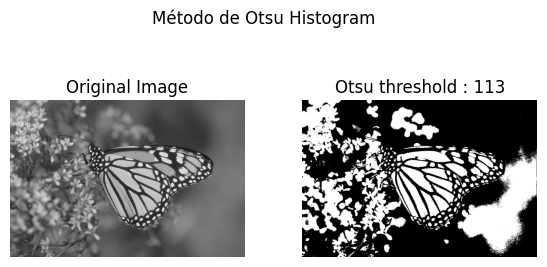

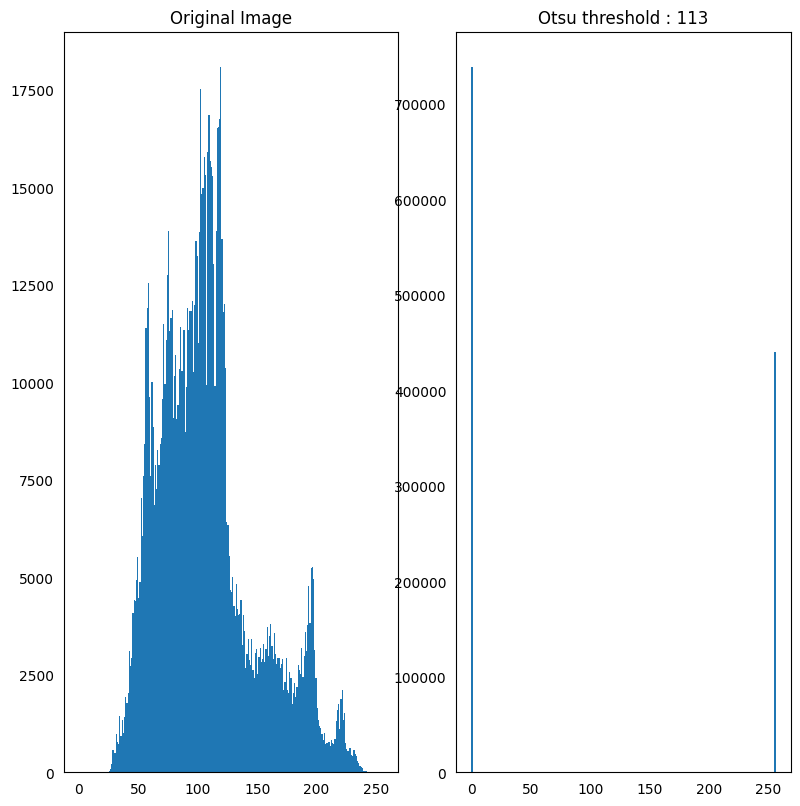

In [36]:
def otsu_method(img):

    # calcula o histograma, normaliza e computa a soma cumulativa
    hist = cv.calcHist([img], [0], None, [256], [0,256])
    hist_norm = hist.ravel() / float(hist.sum())
    c_sum = np.cumsum(hist_norm)

    # calcula a media da soma acumulada isto e a intensidade ate o pixel de valor X
    mean = np.cumsum(hist_norm * np.arange(256))
    mean = mean / (c_sum + 1e-10) # soma 1e-10 para evitar divisão por zero
    
    # a variancia cumulativa mede a dispersao da intensidade dos valores entre as classes de pixels - bg e fg
    # e o valor que queremos maximizar sendo ele o coeficiente de otsu
    var = c_sum * (1 - c_sum) * ((mean - hist_norm) ** 2)
    otsu_th = np.argmax(var)
    return otsu_th



used_img = cidade
kek = otsu_method(used_img)

imgs_q2 = [used_img, thresholding_global(used_img , kek)]
test_q2_label = ["Original Image", "Otsu " + "threshold : " + str(kek)]

fig, axs = plt.subplots(1, 2, figsize=(6,6))
fig.suptitle("Método de Otsu")

fig.tight_layout()
fig.subplots_adjust(top=1.33)

for i in range(2):
    axs[i].imshow(imgs_q2[i])
    axs[i].set_title(test_q2_label[i])
    axs[i].axison = False

fig1, axs1 = plt.subplots(1, 2, figsize=(8,8))
fig.suptitle("Método de Otsu Histogram")

fig1.tight_layout()

for i in range(2):
    axs1[i].hist(imgs_q2[i].ravel(), 256, [0, 256])
    axs1[i].set_title(test_q2_label[i])

# only prints the thresholded image not the og
unique, counts = np.unique(imgs_q2[i], return_counts= True)
show_dict(dict(zip(unique, counts)))


Método de Bernsen

Imagem: 0,0
Pontos brancos 25.96%
Pontos pretos 74.04%
Imagem: 0,1
Pontos brancos 26.98%
Pontos pretos 73.02%
Imagem: 1,0
Pontos brancos 29.88%
Pontos pretos 70.12%
Imagem: 1,1
Pontos brancos 30.91%
Pontos pretos 69.09%


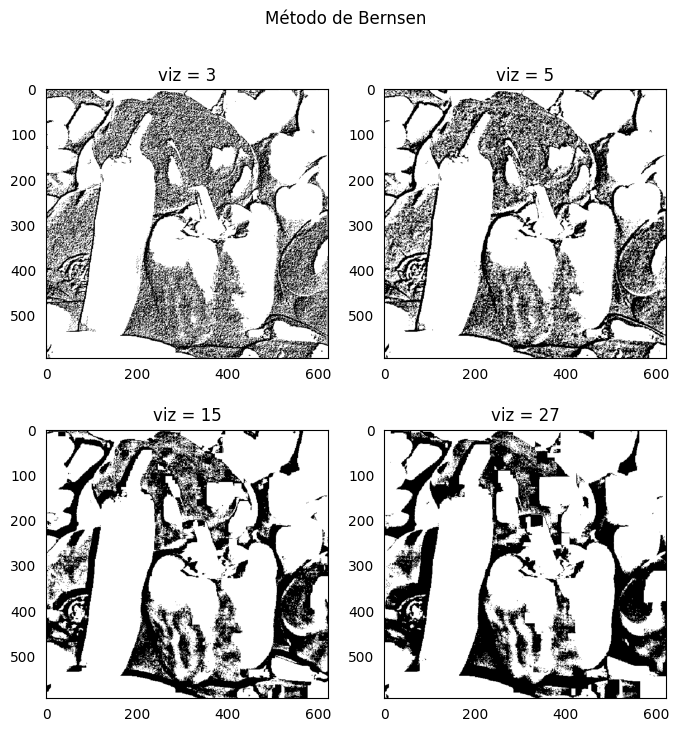

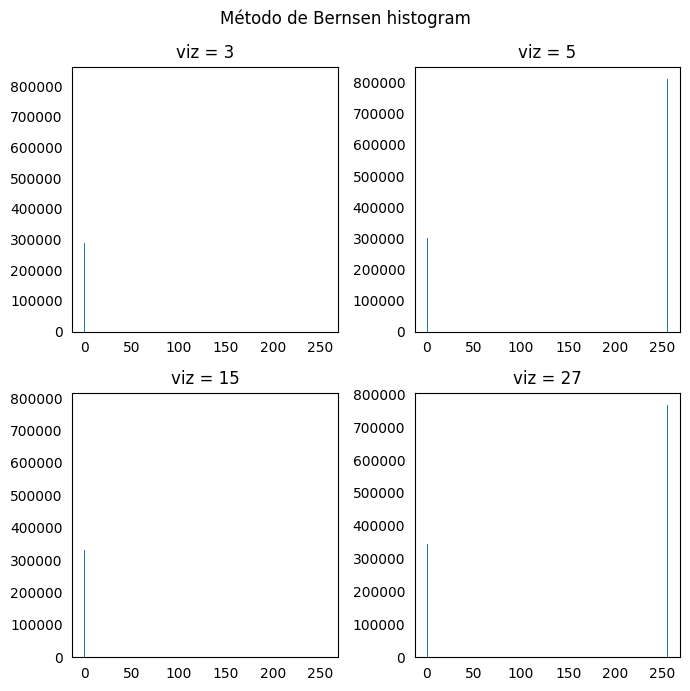

In [32]:
## retorna o valor máximo e minimo de uma matrix na vizinhanca indicada
def get_min_max_by_viz(img, viz):

    if len(img.shape) == 2:
        n, m = img.shape 
    else:
        n, m, _ = img.shape
    img_max = np.zeros_like(img)    
    img_min = np.zeros_like(img)    
    
    used = np.pad(img, viz, mode='reflect')
    for i in range(viz, n + viz):
        for j in range(viz, m + viz):
            value = used[i: i+ viz, j: j + viz]
            img_max[i-viz, j-viz] = np.max(value)
            img_min[i-viz, j-viz] = np.min(value)

    return img_max, img_min

def bernsen(img, viz=2):

    img_max, img_min = get_min_max_by_viz(img, viz)

    threshold_img = (img_max + img_min) / 2

    return thresholding_global(img, threshold_img)


bernsen_param = [[3], [5], [15], [27]]
bernsen_labels = [f"viz = {str(*q)}" for q in bernsen_param]

auto_q7 = Autoplotter(bernsen, peppers, bernsen_param)
auto_q7.generate_plots(bernsen_labels, "Método de Bernsen", top_size=.89)



Método de Niblack

Imagem: 0,0
Pontos brancos 73.08%
Pontos pretos 26.92%
Imagem: 0,1
Pontos brancos 98.14%
Pontos pretos 1.86%
Imagem: 0,2
Pontos brancos 98.92%
Pontos pretos 1.08%
Imagem: 1,0
Pontos brancos 50.70%
Pontos pretos 49.30%
Imagem: 1,1
Pontos brancos 30.70%
Pontos pretos 69.30%
Imagem: 1,2
Pontos brancos 59.48%
Pontos pretos 40.52%


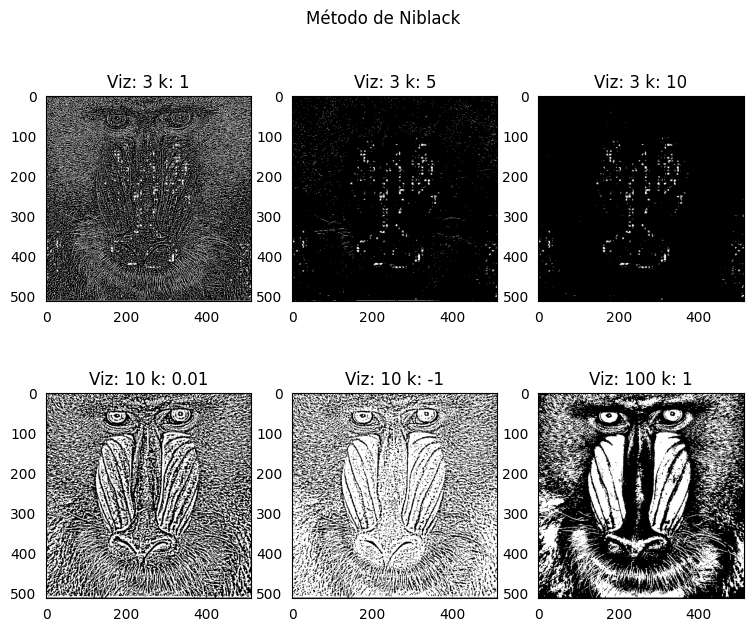

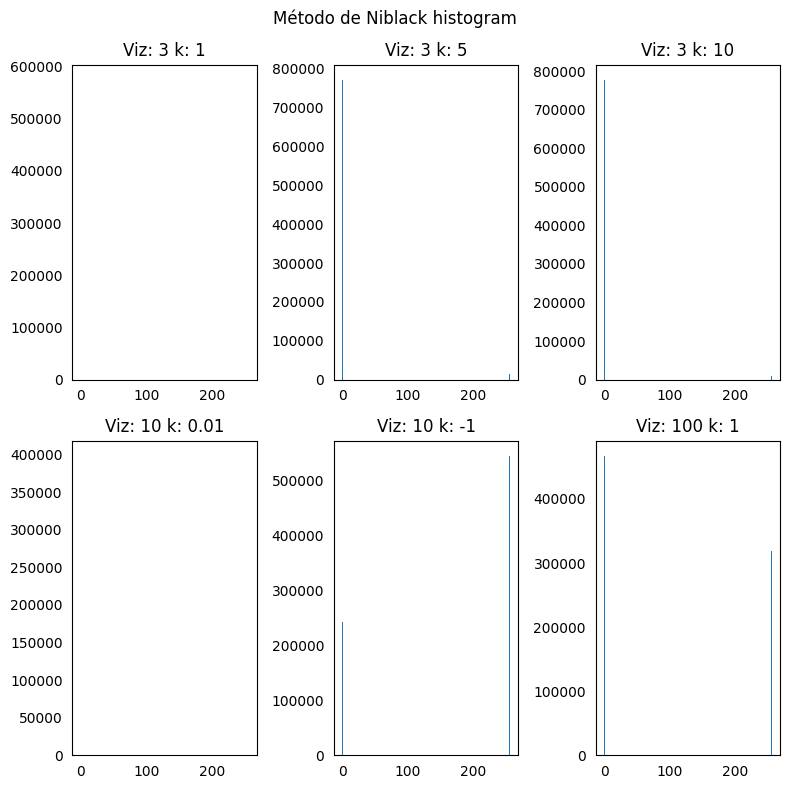

In [ ]:
def niblack(img, viz=3, k=1):
    
    # using convolution to calculate mean and std
    # avoids looping therefore speed ups the code
    # also removes the padding and out bounds problems

    kernel = (1/viz**2) * np.ones((viz,viz))

    # using a "mean kernel"
    mean = cv.filter2D(img, -1, kernel, anchor=(-1, -1), borderType=cv.BORDER_REFLECT)

    # std = sqrt [ (1/n) * (xi - mean)**2) ] -> tirar a media dos valores de (img - mean)**2 basicamente 
    std = np.sqrt(cv.filter2D(((img - mean)**2), -1, kernel, anchor=(-1, -1), borderType=cv.BORDER_REFLECT))


    # vectorized T(x,y) = u(x,y) + k * sigma(x,y)
    niblack_th = mean + k * std

    ## processes the img itself
    res = thresholding_global(img, niblack_th)

    # return niblack_th
    return res


q3_param = [(3,1), (3,5), (3,10), (10, 0.01) , (10, -1), (100, 1)]
q3_labels = ["Viz: " + str(q_p[0]) + " k: " + str(q_p[1]) for q_p in q3_param]

q3 = Autoplotter(niblack, baboon,  q3_param)

q3.generate_plots(q3_labels, 'Método de Niblack', sz=(9,9), top_size=1.1, adjust=-0.5)


# kek = niblack(baboon)
# plt.imshow(kek)


Método de Sauvola e Pietaksinen

Imagem: 0,0
Pontos brancos 0.00%
Pontos pretos 100.00%
Imagem: 0,1
Pontos brancos 23.07%
Pontos pretos 76.93%
Imagem: 1,0
Pontos brancos 31.66%
Pontos pretos 68.34%
Imagem: 1,1
Pontos brancos 45.25%
Pontos pretos 54.75%


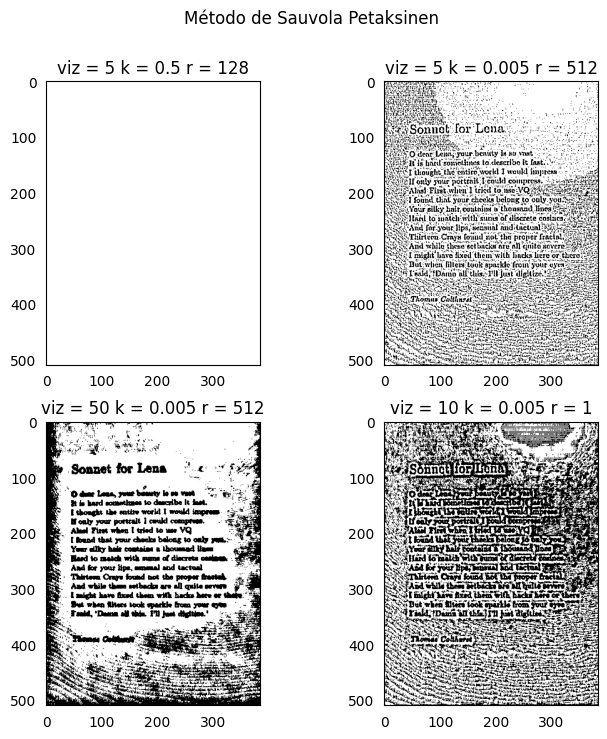

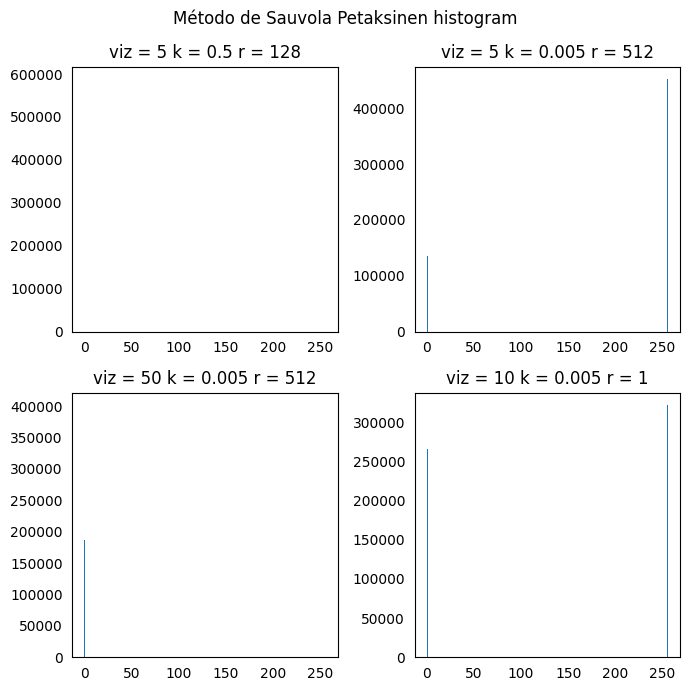

In [ ]:
def sauvola_petaksinen(img, viz = 3, k = 0.5, r = 128):
    
    # using convolution to calculate mean and std
    # avoids looping therefore speed ups the code
    # also removes the padding and out bounds problems

    kernel = (1/viz**2) * np.ones((viz,viz))

    # using a "mean kernel"
    mean = cv.filter2D(img, -1, kernel, anchor=(-1, -1), borderType=cv.BORDER_REFLECT)

    # std = sqrt [ (1/n) * (xi - mean)**2) ] -> tirar a media dos valores de (img - mean)**2 basicamente 
    std = np.sqrt(cv.filter2D(((img - mean)**2), -1, kernel, anchor=(-1, -1), borderType=cv.BORDER_REFLECT))


    # vectorized threshold
    sauvola_petaksinen_th = mean * (1 + (k * ((std/r) - 1)))

    # processes the img itself
    res = thresholding_global(img, sauvola_petaksinen_th)

    return res


q4_param = [(5, 0.5, 128), (5, 0.005, 512), (50, .005, 512), (10, 0.005, 1)]
q4_labels = [f"viz = {str(q[0])} k = {str(q[1])} r = {str(q[2])}" for q in q4_param]


auto_q2 = Autoplotter(sauvola_petaksinen, sea, q4_param)
auto_q2.generate_plots(q4_labels, "Método de Sauvola Petaksinen", top_size=.89)


Método de Phansalskar, More e Sabale

Imagem: 0,0
Pontos brancos 99.86%
Pontos pretos 0.14%
Imagem: 0,1
Pontos brancos 47.73%
Pontos pretos 52.27%
Imagem: 0,2
Pontos brancos 23.53%
Pontos pretos 76.47%
Imagem: 1,0
Pontos brancos 23.53%
Pontos pretos 76.47%
Imagem: 1,1
Pontos brancos 22.42%
Pontos pretos 77.58%
Imagem: 1,2
Pontos brancos 6.06%
Pontos pretos 93.94%


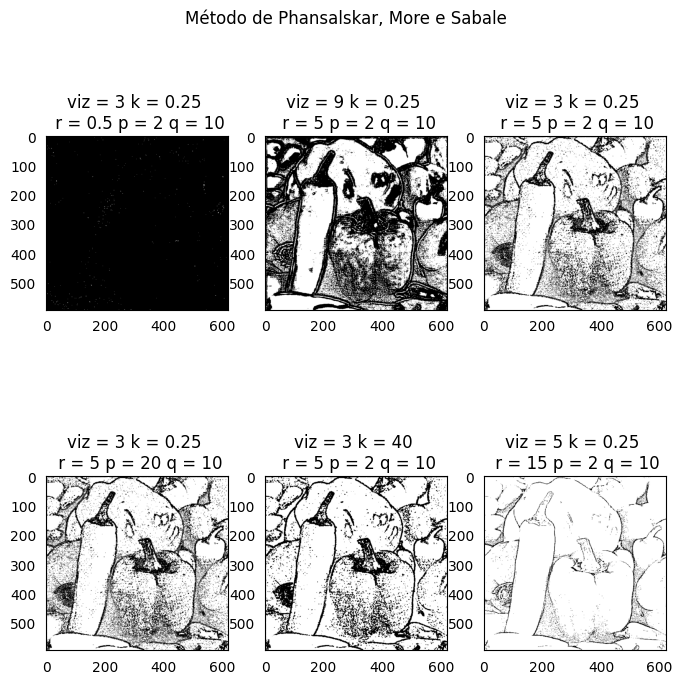

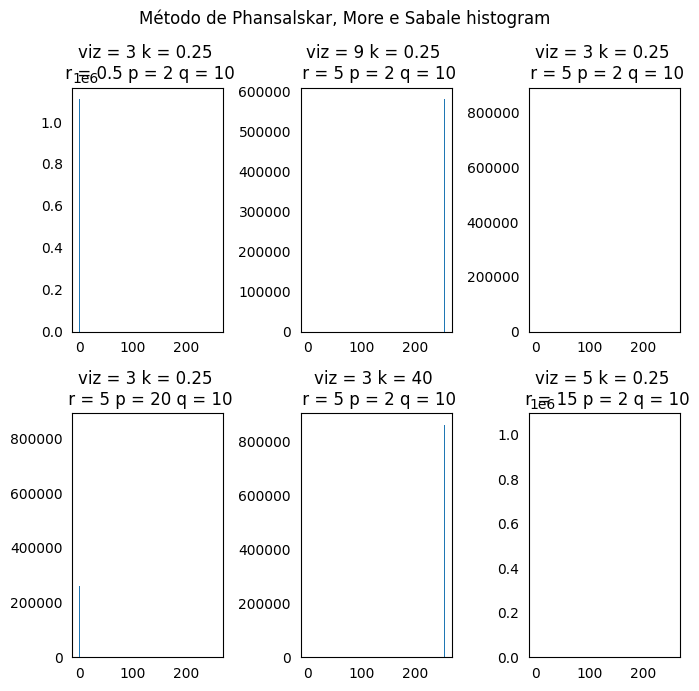

In [59]:
def phansalskar_more_sabale(img, viz=3, k=0.25, r = 0.5, p = 2, q = 10):

    # using convolution to calculate mean and std
    # avoids looping therefore speed ups the code
    # also removes the padding and out bounds problems

    kernel = (1/viz**2) * np.ones((viz,viz))

    # using a "mean kernel"
    mean = cv.filter2D(img, -1, kernel, anchor=(-1, -1), borderType=cv.BORDER_REFLECT)

    # std = sqrt [ (1/n) * (xi - mean)**2) ] -> tirar a media dos valores de (img - mean)**2 basicamente 
    std = np.sqrt(cv.filter2D(((img - mean)**2), -1, kernel, anchor=(-1, -1), borderType=cv.BORDER_REFLECT))

    term_1 = p * np.exp(-q * mean)
    term_2 = k * ((std/r) - 1)

    threshold = mean * ( 1 + term_1 + term_2)


    return thresholding_global(img, threshold)

q5_param = [(3, 0.25, 0.5, 2, 10), (9, 0.25, 5, 2, 10), (3, 0.25, 5, 2, 10), (3, 0.25, 5, 20, 10), (3, 40, 5, 2, 10), (5, 0.25, 15, 2, 10)]
q5_labels = [f"viz = {str(q[0])} k = {str(q[1])} \n r = {str(q[2])} p = {str(q[3])} q = {str(q[4])}" for q in q5_param]


auto_q5 = Autoplotter(phansalskar_more_sabale, peppers, q5_param)
auto_q5.generate_plots(q5_labels, "Método de Phansalskar, More e Sabale", top_size=.89)



Método do Contraste

Imagem: 0,0
Pontos brancos 48.59%
Pontos pretos 51.41%
Imagem: 0,1
Pontos brancos 39.30%
Pontos pretos 60.70%
Imagem: 1,0
Pontos brancos 36.60%
Pontos pretos 63.40%
Imagem: 1,1
Pontos brancos 40.38%
Pontos pretos 59.62%


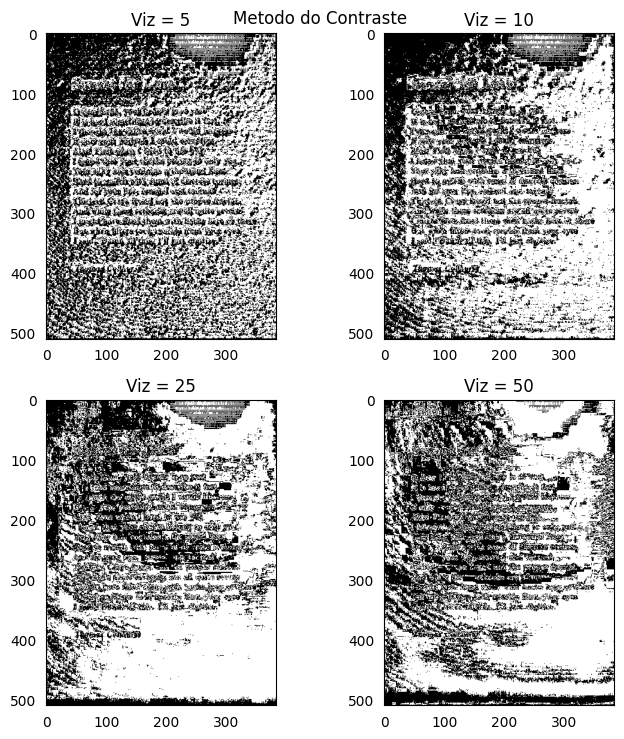

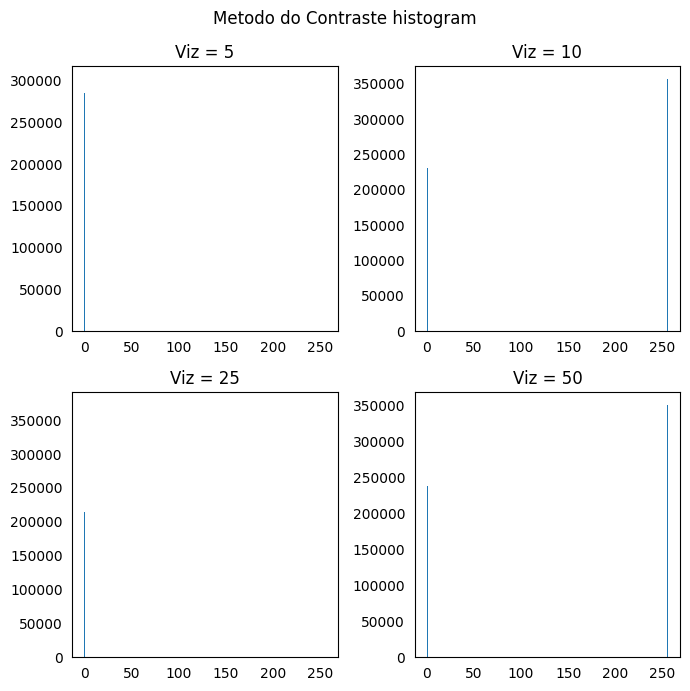

In [64]:
def contraste(img, viz=5):

    res = np.zeros_like(img)

    img_max, img_min = get_min_max_by_viz(img, viz)

    dist_max , dist_min = np.sqrt((img - img_max)**2) , np.sqrt((img - img_min)**2)

    res[dist_max < dist_min] = 255

    return res

test_constraste_parameters = [[5], [10], [25], [50]]
test_constraste_label = ["Viz = " + str(*(t)) for t in test_constraste_parameters]

auto_contraste = Autoplotter(contraste, sea, test_constraste_parameters)
auto_contraste.generate_plots(test_constraste_label, "Metodo do Contraste", sz=(8,8), top_size= 0.95)

Método da Média

Imagem: 0,0
Pontos brancos 45.41%
Pontos pretos 54.59%
Imagem: 0,1
Pontos brancos 44.52%
Pontos pretos 55.48%
Imagem: 1,0
Pontos brancos 27.05%
Pontos pretos 72.95%
Imagem: 1,1
Pontos brancos 44.92%
Pontos pretos 55.08%


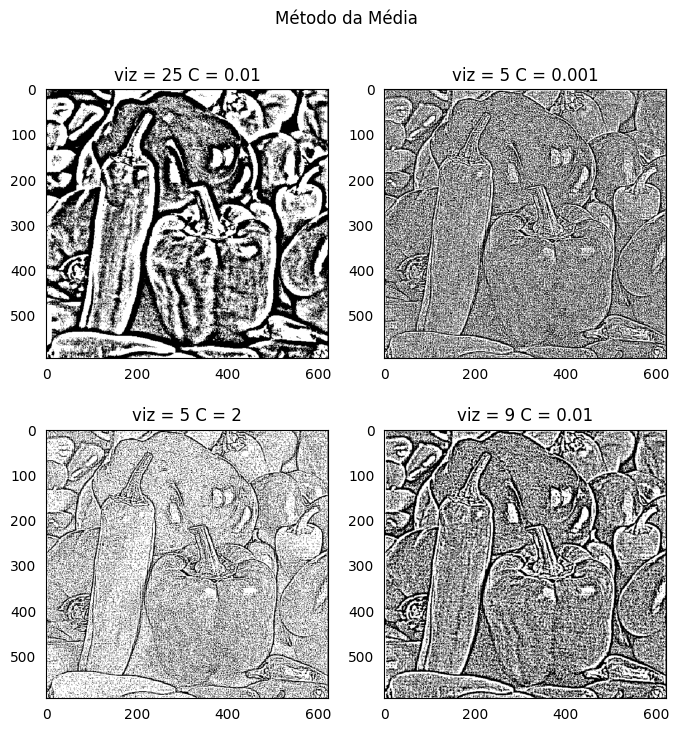

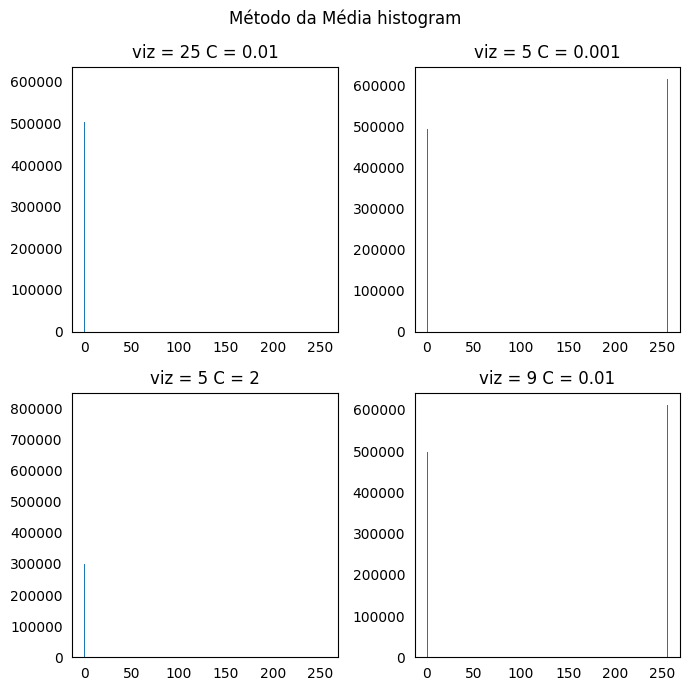

In [62]:
def mean_method(img , viz = 3, C = 15):

    # using convolution to calculate mean and std
    # avoids looping therefore speed ups the code
    # also removes the padding and out bounds problems

    kernel = (1/viz**2) * np.ones((viz,viz))

    # using a "mean kernel"
    mean = cv.filter2D(img, -1, kernel, anchor=(-1, -1), borderType=cv.BORDER_REFLECT)
    th_mean = mean - C
    return thresholding_global(img, th_mean)


q6_param = [(25, 0.01), (5, 0.001), (5, 2), (9, 0.01)]
q6_labels = [f"viz = {str(q[0])} C = {str(q[1])}" for q in q6_param]


auto_q6 = Autoplotter(mean_method, peppers, q6_param)
auto_q6.generate_plots(q6_labels, "Método da Média", top_size=.89)



Método da Mediana


Imagem: 0,0
Pontos brancos 36.55%
Pontos pretos 63.45%
Imagem: 0,1
Pontos brancos 44.79%
Pontos pretos 55.21%
Imagem: 1,0
Pontos brancos 48.16%
Pontos pretos 51.84%
Imagem: 1,1
Pontos brancos 48.23%
Pontos pretos 51.77%


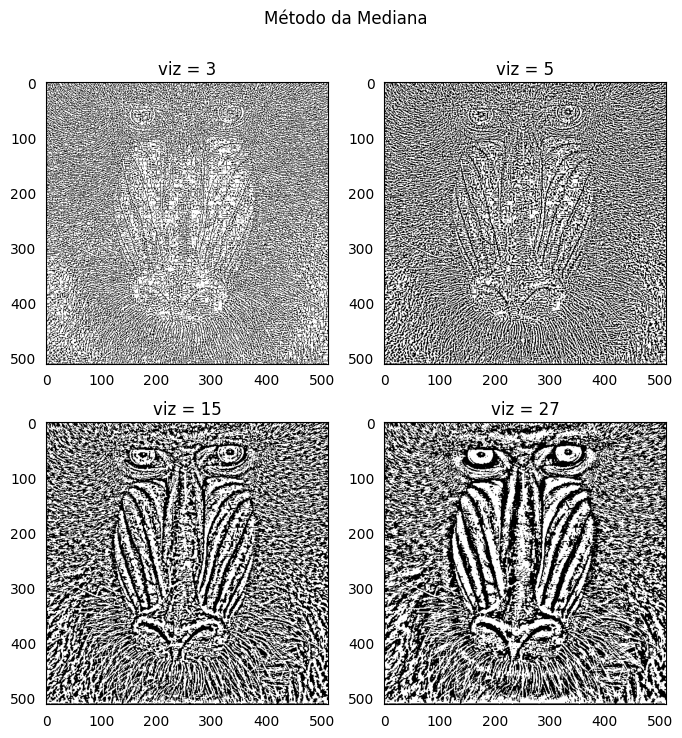

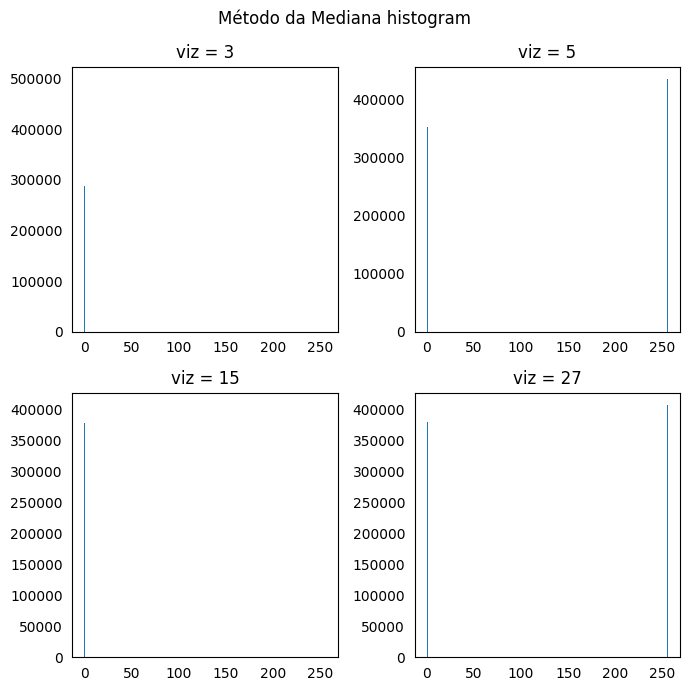

In [ ]:
def mediana(img, viz=3):

    median = cv.medianBlur(img, viz)
 
    return thresholding_global(img, median)

q7_param = [[3], [5], [15], [27]]
q7_labels = [f"viz = {str(*q)}" for q in q7_param]


auto_q7 = Autoplotter(mediana, baboon, q7_param)
auto_q7.generate_plots(q7_labels, "Método da Mediana", top_size=.89)
